In [ ]:
# 패키지 설치
!pip install konlpy
!pip install wordcloud
!pip install pandas matplotlib

In [ ]:
# 한글 폰트 설치 및 확인
!apt-get update -qq
!apt-get install -qq fonts-nanum
!fc-list :lang=ko

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf: NanumSquareRound,나눔스퀘어라운드,NanumSquareRound Bold,나눔스퀘어라운드 Bold:style=Bold,Regular
/usr/share/fonts/truetype/nanum/NanumGothicCodingBold.ttf: NanumGothicCoding,나눔고딕코딩:style=Bold
/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf: NanumSquareRound,나눔스퀘어라운드,NanumSquareRound Regular,나눔스퀘어라운드 Regular:style=Regular
/usr/share/fonts/truetype/nanum/NanumSquareB.ttf: NanumSquare,나눔스퀘어,NanumSquare Bold,나눔스퀘어 Bold:style=Bold
/usr/share/fo

# **1. 데이터 전처리**
* 추출한 텍스트 데이터를 바탕으로 전처리 하는 코드.
* 키워드를 추출하여 csv 파일로 저장함.  


(전체 데이터 제공받은 후 형식에 맞게 수정 필요, 불용어도 추가 예정)

In [ ]:
import pandas as pd
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# KoNLPy의 Okt 분석기
from konlpy.tag import Okt


# 파일명 설정
RAW_TEXT_FILE = 'data.txt'
OUTPUT_CSV_FILE = 'keyword_processed_data.csv'

# KoNLPy의 Okt 분석기 초기화(Okt는 명사를 추출함)
okt = Okt()

# KoNLPy의 Okt 분석기 초기화(Okt는 명사를 추출함)
okt = Okt()

# 분석에 불필요한 단어 정의(불용어)
custom_stopwords = ['년', '월', '일', '등', '것', '수', '위해', '참여', '보고서', '학년', '시간', '과정', '통해', '함께', '또한', '진로', '자신', '대한', '대해',
                    '활동', '관련', '관심', '분야', '계기', '생각', '학급']


# 데이터 추출 함수

# 태그 제거 및 공백 정리
def clean_line_tag(line):
    cleaned_line = re.sub(r'\\', '', line)
    return cleaned_line.strip()

# 학과, 전형, 창체 기록 추출
def extract_raw_data(file_path):
    students_data = []

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            raw_text = f.read()
    except FileNotFoundError:
        print(f"오류: 파일을 찾을 수 없습니다: {file_path}")
        return pd.DataFrame()

    blocks = raw_text.strip().split('---')

    for i, block in enumerate(blocks):
        block_text = block.strip()
        if not block_text:
            continue

        lines = [line.strip() for line in block_text.split('\n') if line.strip()]

        if len(lines) < 3:
            continue

        original_creative_text = ' '.join(lines[2:])

        record = {
            '학과': clean_line_tag(lines[0]),
            '전형': clean_line_tag(lines[1]),
            '창체 기록_원본': original_creative_text.strip()
        }
        students_data.append(record)

    return pd.DataFrame(students_data)


# 최종 전처리 함수 (Okt 명사 추출 방식)
def preprocess_text_okt_nouns(text, analyzer, custom_stopwords):
    if not isinstance(text, str) or not text.strip():
        return ''

    # 숫자, 특수문자 제거 (명사 추출 전 수행)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'[0-9]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Okt 분석기로 명사만 추출 (서술어 자동 제거)
    try:
        tokens = analyzer.nouns(text)
    except Exception as e:
        # Okt 분석 중 오류 발생 시 건너뜀
        print(f"⚠️ Okt 분석 중 오류 발생, 해당 텍스트를 건너뜁니다: {e}")
        return ''

    # 필터링 (불용어 및 길이)
    final_tokens = [
        word for word in tokens
        if word not in custom_stopwords and len(word) > 1
    ]

    return ', '.join(final_tokens)

In [ ]:
# 데이터 로드 및 정리
data_df = extract_raw_data(RAW_TEXT_FILE)

if data_df.empty:
    raise Exception("데이터 로드 실패. 파일 경로 및 형식을 확인하세요.")

print(f"✅ 총 {len(data_df)}명의 학생 데이터 로드 완료")

# 결측값(NaN) 및 공백 값 정리
data_df['창체 기록_원본'] = data_df['창체 기록_원본'].fillna('')
data_df = data_df[data_df['창체 기록_원본'].str.strip().str.len() > 0].copy()

print(f"✅ 데이터 정리 완료. 최종 데이터 행 수: {len(data_df)}")

# 상위 5개 행 출력(확인용)
print(data_df.head())

✅ 총 4명의 학생 데이터 로드 완료
✅ 데이터 정리 완료. 최종 데이터 행 수: 4
       학과  전형                                           창체 기록_원본
0  식품영양학과  정시  나의주장발표수업(2017.06.12.)에서 시선처리등 여러면에서 조금씩 아쉬운 점은...
1  컴퓨터과학과  수시  과학의 달을 맞아 개최한 '과학 한마당(2021. 04, 30.)' 행사에 참여하여...
2  컴퓨터과학과  정시  1학기 학급 독서 프로그램(인문학편)에서 '레 미제라블(빅토르 위고)'을 읽고, '...
3  컴퓨터과학과  정시  학기 초 자원하여 학급 출석부 관리를 맡아 1년간 책임감 있게 봉사하였으며, 지속적...


In [ ]:
# 전처리를 적용 및 명사 리스트 컬럼 생성

# Okt 분석기, 불용어 리스트 사용하여 전처리 적용
data_df['명사 리스트'] = data_df['창체 기록_원본'].apply(
    lambda x: preprocess_text_okt_nouns(x, okt, custom_stopwords))

print("✅ 전처리 완료")

#상위 5개 행 출력(확인용)
print(data_df[['학과', '전형', '명사 리스트']].head())

✅ 전처리 완료
       학과  전형                                             명사 리스트
0  식품영양학과  정시  주장, 발표, 수업, 시선, 처리, 대체로, 피치, 능력, 조선, 임진왜란, 승리,...
1  컴퓨터과학과  수시  과학, 개최, 과학, 마당, 행사, 통합, 과학, 생명체, 구성, 탄소, 화합물, ...
2  컴퓨터과학과  정시  학기, 독서, 프로그램, 인문학, 미제, 빅토르, 위고, 옥살이, 범죄, 책임, 산...
3  컴퓨터과학과  정시  학기, 자원, 출석, 관리, 책임감, 봉사, 지속, 자기, 반성, 노력, 기본, 마...


In [ ]:
# 최종 결과 CSV파일로 저장
data_df.to_csv(OUTPUT_CSV_FILE, index=False, encoding='utf-8-sig')

print(f"\n✅ '{OUTPUT_CSV_FILE}' 파일 저장 완료")


✅ 'keyword_processed_data.csv' 파일 저장 완료


# **2. 키워드 빈도 분석 (wordcloud)**  
* 전체 및 학과, 전형 별 워드 클라우드 생성  
* 주요 키워드(상위 10개) 개수 출력
* 학과별 워드 클라우드에서 컴퓨터과학과가 가장 먼저 출력되도록 함
* 학과별, 전형별 워드 클라우드에서 캔버스가 2개씩 출력되며 각 캔버스 밑에 개수가 출력되도록 함





In [ ]:
import matplotlib.font_manager as fm
import pandas as pd

# 폰트 지정
FONT_PATH = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 저장된 파일 이름 확인
INPUT_CSV_FILE = 'keyword_processed_data.csv'

# 전처리 완료된 CSV 파일 로드
analysis_df = pd.read_csv(INPUT_CSV_FILE, encoding='utf-8-sig')

# 폰트 속성 객체 생성 (제목 깨짐 방지용)
title_font_prop = fm.FontProperties(fname=FONT_PATH, size=18)

In [ ]:
# 상위 10개 키워드 개수 계산 및 출력 함수
from collections import Counter
import math
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def keyword_counts(group_name, text_data):
    if not text_data.strip():
        return {
            'major': group_name,
            'keywords': ["키워드 데이터가 비어 있습니다."]
        }

    # 텍스트 데이터를 공백 기준으로 토큰화하고 빈도 계산
    tokens = text_data.split(' ')
    word_counts = Counter(tokens)

    # 공백 토큰 제거
    if '' in word_counts:
        del word_counts['']

    top_10 = word_counts.most_common(10)

    # 학과명과 키워드 목록을 딕셔너리로 반환
    return {
        'major': group_name,
        'keywords': [f"{keyword}: {count}개" for keyword, count in top_10]
    }


# 주요 키워드 목록 출력 위치 지정 함수
def plot_keywords_on_axis(keywords_list, ax_text, font_prop, font_size=14):
    header = "[주요 키워드 개수]"
    text_content = header + "\n" + "\n".join(keywords_list)

    # 텍스트 영역에 주요 키워드 개수 출력
    ax_text.text(
        0.0, 0.95,
        text_content,
        transform=ax_text.transAxes,
        fontproperties=font_prop,
        fontsize=font_size,
        verticalalignment='top',
        horizontalalignment='left',
        color='black'
    )
    ax_text.axis('off') # 축 숨기기

### **전체 워드 클라우드**

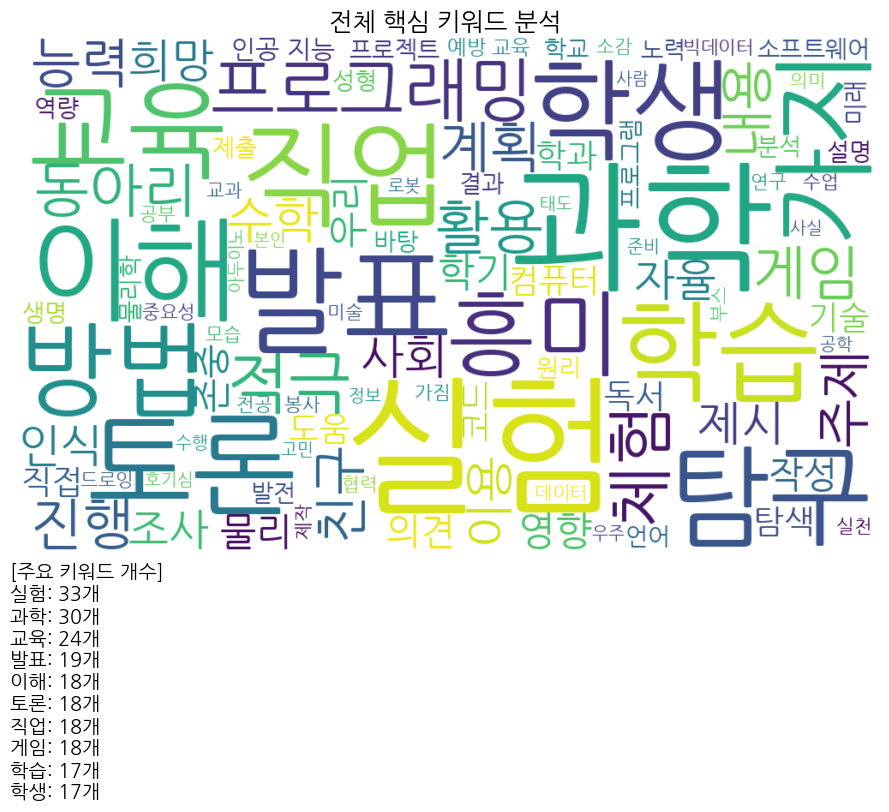

In [ ]:
# 워드 클라우드 시각화
# 전체 워드 클라우드

all_words = ' '.join(analysis_df['명사 리스트'].str.replace(',', ' ').dropna())

wc = WordCloud(
    font_path=FONT_PATH,
    width=1000,
    height=600,
    background_color='white',
    max_words=100,
    prefer_horizontal=0.9
)
wordcloud = wc.generate(all_words)

# 키워드 데이터 추출
result = keyword_counts("전체 분석", all_words)
keywords_list = result['keywords']

# 캔버스와 GridSpec 설정
fig = plt.figure(figsize=(9, 8))
gs_main = GridSpec(1, 1, figure=fig)

# 중첩 GridSpec 생성(워드 클라우드와 텍스트가 겹치지 않도록 분리)
gs_nested = gs_main[0].subgridspec(10, 1, hspace=0.1)

ax_wc = fig.add_subplot(gs_nested[0:8, 0])  # 워드 클라우드 영역 (상단 80%)
ax_text = fig.add_subplot(gs_nested[8:10, 0]) # 텍스트 영역 (하단 20%)

# 워드 클라우드 시각화
ax_wc.imshow(wordcloud, interpolation='bilinear')
ax_wc.axis('off')
ax_wc.set_title("전체 핵심 키워드 분석", fontproperties=title_font_prop)

# 키워드 개수 출력
plot_keywords_on_axis(keywords_list, ax_text, title_font_prop, font_size=14)

plt.tight_layout()
plt.show()

### **학과별 워드 클라우드**

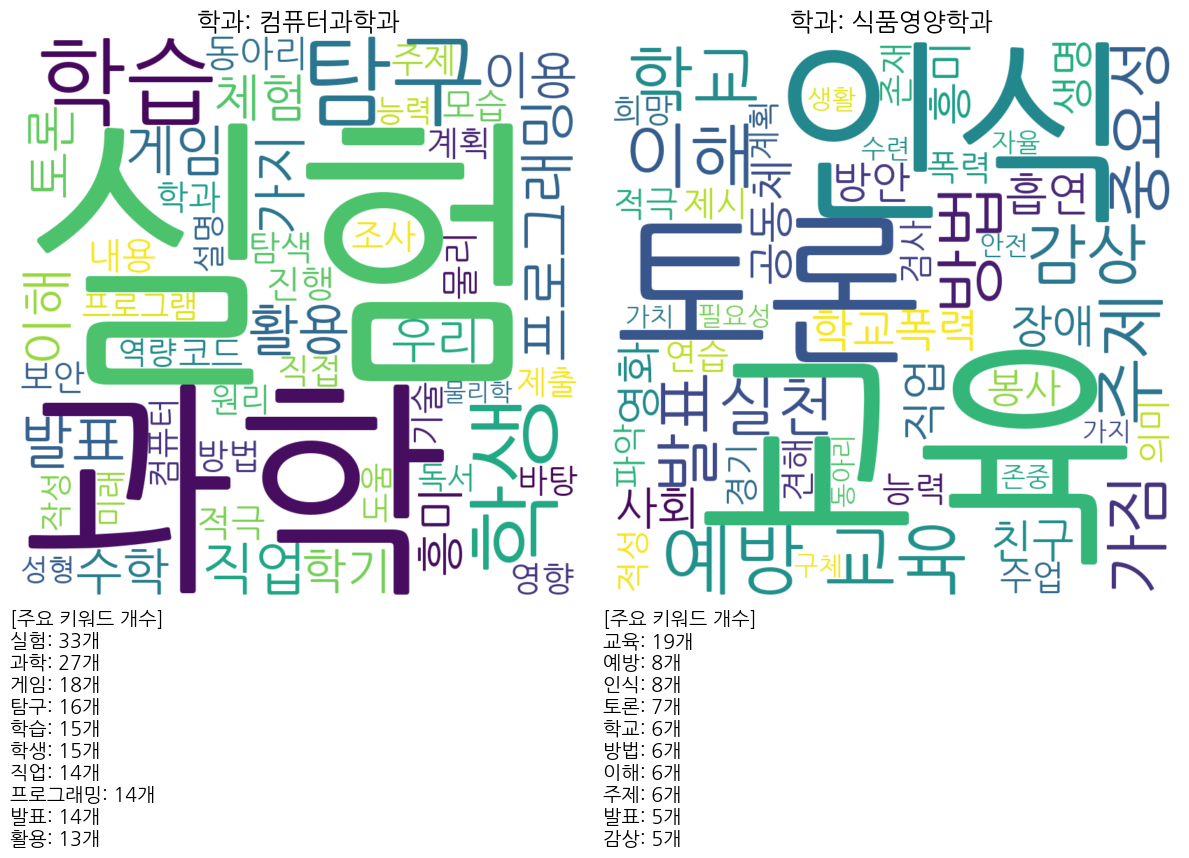

In [ ]:
# 학과별 워드 클라우드
grouped_data = analysis_df.groupby('학과')['명사 리스트'].apply(
    lambda x: ' '.join(x.str.replace(',', ' ').dropna())
)

# 컴퓨터과학과가 가장 먼저 출력되도록 지정
TARGET_MAJOR = '컴퓨터과학과'
ordered_data = []

# 컴퓨터과학과 데이터 추출 및 맨 앞에 추가
if TARGET_MAJOR in grouped_data:
    ordered_data.append((TARGET_MAJOR, grouped_data[TARGET_MAJOR]))

    # 나머지 학과 데이터 추가
    remaining_items = [(major, text)
                       for major, text in grouped_data.items()
                       if major != TARGET_MAJOR]
    ordered_data.extend(remaining_items)
else:
    ordered_data = list(grouped_data.items())

num_groups = len(ordered_data)
MAX_COLS = 2 # 각 행에 캔버스 2개씩 출력

# 그룹화된 데이터가 있을 경우 시각화 진행
if num_groups > 0:
    # 총 필요한 행 수 계산
    nrows = math.ceil(num_groups / MAX_COLS)
    fig = plt.figure(figsize=(6 * MAX_COLS, 8.5 * nrows))

    # 메인 GridSpec 생성
    gs_main = GridSpec(nrows, MAX_COLS, figure=fig)

    # 워드 클라우드 생성
    # ordered_data 순회 (정해진 순서대로 순회)
    for i, (major, text) in enumerate(ordered_data):

        # 현재 학과가 들어갈 위치 계산
        row_idx = i // MAX_COLS
        col_idx = i % MAX_COLS

        # 해당 위치에 중첩 GridSpec 생성(워드클라우드와 텍스트가 겹치지 않도록 함)
        gs_nested = gs_main[row_idx, col_idx].subgridspec(10, 1, hspace=0.1)

        # 서브 영역 할당
        ax_wc = fig.add_subplot(gs_nested[0:8, 0])  # 워드 클라우드 영역 (상단 80%)
        ax_text = fig.add_subplot(gs_nested[8:10, 0]) # 키워드 텍스트 영역 (하단 20%)

        # 워드 클라우드 및 데이터 처리
        result = keyword_counts(major, text)
        keywords_list = result['keywords']

        wc_major = WordCloud(
            font_path=FONT_PATH,
            width=800,
            height=800,
            background_color='white',
            max_words=50
        )
        wordcloud_major = wc_major.generate(text)

        # 워드 클라우드 시각화
        ax_wc.imshow(wordcloud_major, interpolation='bilinear')
        ax_wc.axis('off')
        ax_wc.set_title(f"학과: {major}", fontproperties=title_font_prop)

        # 주요 키워드 개수 출력
        plot_keywords_on_axis(keywords_list, ax_text, title_font_prop, font_size=14)

    plt.tight_layout()
    plt.show()

else:
    print("\n학과별 그룹화할 데이터가 충분하지 않습니다.")

### **전형별 워드 클라우드**

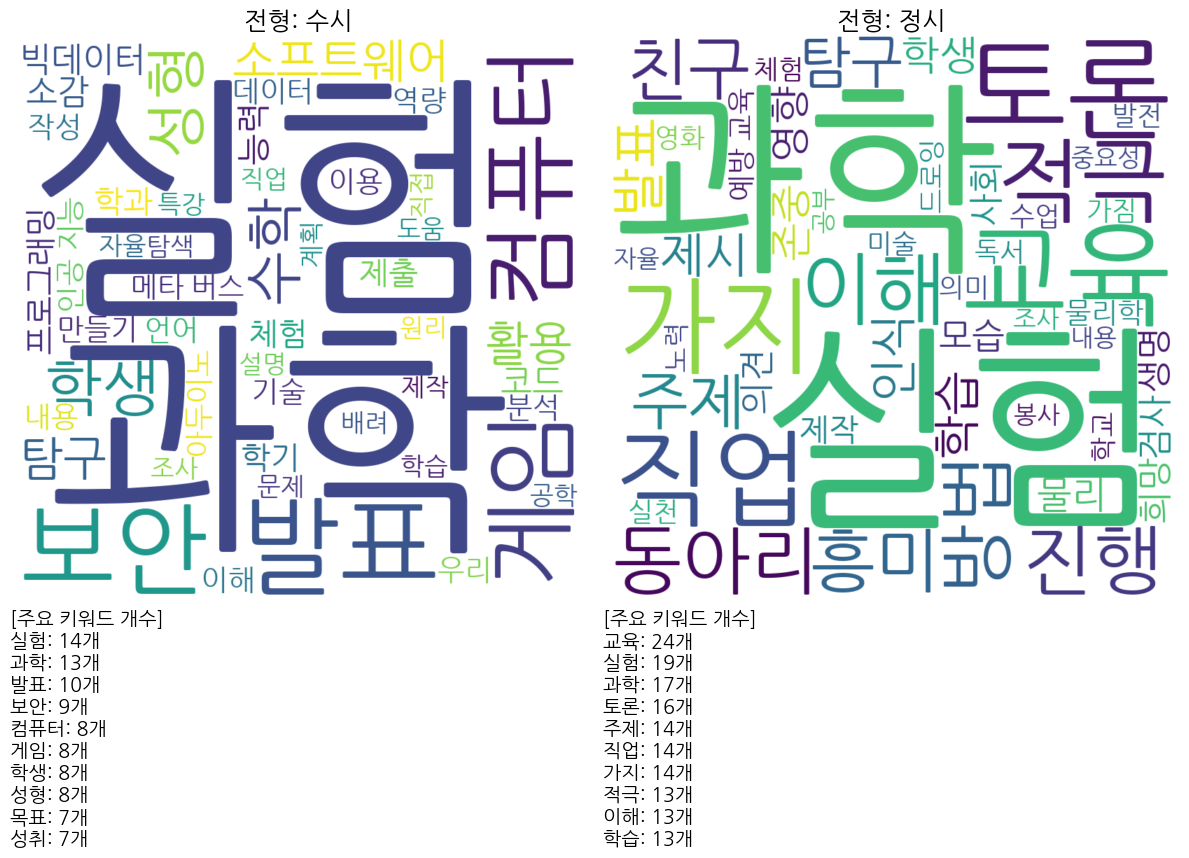

In [ ]:
# 전형별 워드 클라우드
grouped_data2 = analysis_df.groupby('전형')['명사 리스트'].apply(
    lambda x: ' '.join(x.str.replace(',', ' ').dropna())
)
num_groups = len(grouped_data2)
MAX_COLS = 2 # 각 행에 캔버스 2개씩 출력

if num_groups > 0:

    # 총 필요한 행 수 계산
    nrows = math.ceil(num_groups / MAX_COLS)
    fig = plt.figure(figsize=(6 * MAX_COLS, 8.5 * nrows))

    # 메인 GridSpec 생성
    gs_main = GridSpec(nrows, MAX_COLS, figure=fig)

    # 전형별 워드 클라우드 생성
    for i, (type, text) in enumerate(grouped_data2.items()):

        # 현재 전형이 들어갈 위치 계산
        row_idx = i // MAX_COLS
        col_idx = i % MAX_COLS

        # 해당 위치에 중첩 GridSpec 생성
        gs_nested = gs_main[row_idx, col_idx].subgridspec(10, 1, hspace=0.1)

        # 서브 영역 할당
        ax_wc = fig.add_subplot(gs_nested[0:8, 0]) # 워드 클라우드 영역
        ax_text = fig.add_subplot(gs_nested[8:10, 0]) # 텍스트 영역

        # 워드 클라우드 및 데이터 처리
        result = keyword_counts(type, text)
        keywords_list = result['keywords']

        wc_type = WordCloud(
            font_path=FONT_PATH,
            width=800,
            height=800,
            background_color='white',
            max_words=50
        )
        wordcloud_type = wc_type.generate(text)

        # 워드 클라우드 시각화
        ax_wc.imshow(wordcloud_type, interpolation='bilinear')
        ax_wc.axis('off')
        ax_wc.set_title(f"전형: {type}", fontproperties=title_font_prop)

        # 주요 키워드 개수 출력
        plot_keywords_on_axis(keywords_list, ax_text, title_font_prop, font_size=14)

    plt.tight_layout()
    plt.show()

else:
    print("\n'전형'별 그룹화할 데이터가 충분하지 않습니다.")

# **3. 키워드 유사성 분포 분석(PCA)**  
유사한 키워드들이 이루는 군집을 통해 공통점, 차이점을 분석함  
(미완성, 데이터 제공 받은 후 수정 예정)

✅ TF-IDF 벡터 차원: (4, 300)
✅ PCA 완료. 총 분산 설명률: 74.93%
   Principal Component 1  Principal Component 2      학과
0              -0.554858              -0.503974  식품영양학과
1               0.475680               0.163769  컴퓨터과학과
2              -0.401441               0.590713  컴퓨터과학과
3               0.480620              -0.250508  컴퓨터과학과


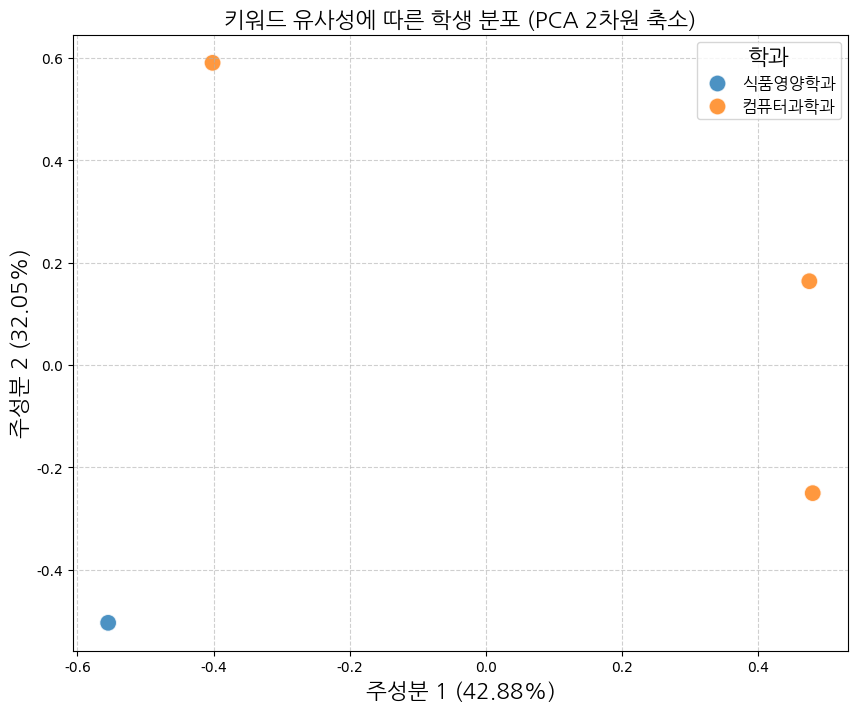

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

INPUT_CSV_FILE = 'keyword_processed_data.csv'
FONT_PATH = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'


# 한글 깨짐 방지 폰트 설정
font_name = fm.FontProperties(fname=FONT_PATH).get_name()
plt.rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지
title_font_prop = fm.FontProperties(fname=FONT_PATH, size=16)

# 전처리 완료된 CSV 파일 로드
try:
    analysis_df = pd.read_csv(INPUT_CSV_FILE, encoding='utf-8-sig')
    analysis_df['명사 리스트'] = analysis_df['명사 리스트'].fillna('')
    analysis_df = analysis_df[analysis_df['명사 리스트'].str.strip().str.len() > 0].copy()
    N = len(analysis_df)
except FileNotFoundError:
    print(f"오류: '{INPUT_CSV_FILE}' 파일을 찾을 수 없습니다.")
    exit()

# TF-IDF 벡터화]

tfidf_vectorizer = TfidfVectorizer(max_features=300, token_pattern=r'\b\w+\b')
documents = analysis_df['명사 리스트'].str.replace(', ', ' ').tolist()
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

# PCA를 위해 희소 행렬을 밀집 행렬(numpy array)로 변환
tfidf_array = tfidf_matrix.toarray()
print(f"✅ TF-IDF 벡터 차원: {tfidf_array.shape}")


# PCA 수행
# 주성분 2개로 차원 축소
pca = PCA(n_components=2)

# PCA 모델 학습 및 데이터 변환
pca_results = pca.fit_transform(tfidf_array)

# PCA 결과를 DataFrame으로 정리
pca_df = pd.DataFrame(data=pca_results, columns=['Principal Component 1', 'Principal Component 2'])
# 학과 정보 병합 (시각화 색상 구분을 위함)
pca_df = pd.concat([pca_df, analysis_df[['학과']].reset_index(drop=True)], axis=1)

print(f"✅ PCA 완료. 총 분산 설명률: {pca.explained_variance_ratio_.sum()*100:.2f}%")
print(pca_df.head(N))

plt.figure(figsize=(10, 8))
# Seaborn을 사용하여 학과별로 색깔을 구분하여 산점도 생성
sns.scatterplot(
    x='Principal Component 1',
    y='Principal Component 2',
    hue='학과',
    data=pca_df,
    s=150,
    alpha=0.8
)

plt.title('키워드 유사성에 따른 학생 분포 (PCA 2차원 축소)', fontproperties=title_font_prop)
plt.xlabel(f'주성분 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)', fontproperties=title_font_prop)
plt.ylabel(f'주성분 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)', fontproperties=title_font_prop)

legend = plt.legend(title='학과', loc='best')
plt.setp(legend.get_title(), fontproperties=title_font_prop)
for text in legend.get_texts():
    text.set_font_properties(fm.FontProperties(fname=FONT_PATH, size=12))

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()